In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [39]:
!pip uninstall -qqy jupyterlab jupyterlab-lsp # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

In [40]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

In [41]:
## setup api key
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

## Google Search grounding

In [42]:
## Automated retry
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)


In [43]:
# Ask for information without search grounding.
response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Billie Eilish's next concert?")

Markdown(response.text)

Unfortunately, I cannot provide you with a definitive answer for Billie Eilish's next concert. The scheduling and announcement of concert dates are dynamic and can change quickly.

**To find the most up-to-date information about Billie Eilish's upcoming concerts, I recommend checking these official sources:**

*   **Billie Eilish's Official Website:** This is the best place for official announcements: [https://www.billieeilish.com/](https://www.billieeilish.com/)
*   **Billie Eilish's Social Media:** Follow her on platforms like Instagram, Twitter/X, and Facebook for real-time updates.
*   **Ticketmaster or other official ticketing vendors:** Once dates are announced, they will be listed on ticket selling platforms like Ticketmaster.
*   **Google Search:** Do a Google search for "Billie Eilish tour dates" or "Billie Eilish concerts".
*   **Reputable Concert Listing Websites:** Look at websites that compile concert schedules like Bandsintown or Songkick, but verify the information with official sources.



In [45]:
## Now with grounding enabled
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="When and where is Billie Eilish's next concert?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

Billie Eilish is currently on her "HIT ME HARD AND SOFT: THE TOUR". Here are some of her upcoming concert dates and locations:

*   **April 23, 2025:** Avicii Arena, Stockholm, Sweden
*   **April 24, 2025:** Avicii Arena, Stockholm, Sweden
*   **April 26, 2025:** Unity Arena, Fornebu, Norway
*   **April 28, 2025:** Royal Arena, Copenhagen, Denmark
*   **April 29, 2025:** Royal Arena, Copenhagen, Denmark
*   **May 2, 2025:** ZAG Arena, Hannover, Germany
*   **May 4, 2025:** Ziggo Dome, Amsterdam, Netherlands
*   **May 5, 2025:** Ziggo Dome, Amsterdam, Netherlands



In [46]:
## Response MetatData
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = query_with_grounding()

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

gigsandtours.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALMt9bgQHyAA1vOXcIXfxYXeuaubCs-1h_rNTLc1q09OfQlXpLI6kjaZ8i5Nuz7Nj7iJbVz6AKIaW6buwLqlyq6U4WCAmpLOVB9DRD86ssM2m0yU3lUd6r-uq2qkFnHwxVTNBdMqc8J-z0=
ticketmaster.co.uk: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALZeA-PDUufEGUEosfCacuFd3Ro0cPpVf-0P81J0_mbDbl7FcJGVv-QdGujXs7ehvtz2YxvVkS7q7luKAzWf4gw7Nn0HtGra3bo3B7uAfaabzenmCxL23lVCoJV6iQnNi2iGZw1JVpVkPqp_vFxzEq1y9ykcbiA4i5QC66mTw==
ticketmaster.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJQJprK2VLzo4up8AlDxQYkenF8iRVMpTGZOvkZUyhmBB-57F8tZ5FIULGi_oKesiBC7x1UWJl_49bnAZR24nlMV2Rs0ZN4v96nA4IEebC7NHk5QBXwy-EDnggVSZpa-VaD2SRMqSmAe25YNsDQHjr-OExun4kaIv_WoHI=
billieeilishtours2025.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKfy12Dq7iaOv6EAUu293SW2m_L5LYEM9GBC6VxFAuUIeMw5zVEEWJ1Nn_dDqrqbYCdieJQkWaNKfqj8xxIASAoSfuY7ypsiWIoWOMNbwGcvVUpaMvb05jjNYpxIMW4B28=
billieeilish.com: https://ver

In [47]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)


In [48]:
from pprint import pprint

supports = rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.89961565, 0.6507133, 0.73002756],
 'grounding_chunk_indices': [0, 1, 2],
 'segment': {'end_index': 67,
             'text': 'Billie Eilish is currently on her "HIT ME HARD AND SOFT: '
                     'THE TOUR".'}}
{'confidence_scores': [0.63044053, 0.6192324],
 'grounding_chunk_indices': [3, 1],
 'segment': {'end_index': 183,
             'start_index': 128,
             'text': '*   **April 23, 2025:** Avicii Arena, Stockholm, Sweden'}}
{'confidence_scores': [0.61363846, 0.6024498],
 'grounding_chunk_indices': [3, 1],
 'segment': {'end_index': 239,
             'start_index': 184,
             'text': '*   **April 24, 2025:** Avicii Arena, Stockholm, Sweden'}}
{'confidence_scores': [0.7899449, 0.6866594, 0.6311952, 0.60849315],
 'grounding_chunk_indices': [4, 5, 3, 1],
 'segment': {'end_index': 292,
             'start_index': 240,
             'text': '*   **April 26, 2025:** Unity Arena, Fornebu, Norway'}}
{'confidence_scores': [0.6320993, 0.60163087],

In [49]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        rc.content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * Billie Eilish is currently on her "HIT ME HARD AND SOFT: THE TOUR".<sup>[1]</sup><sup>[2]</sup><sup>[3]</sup>

 * *   **April 23, 2025:** Avicii Arena, Stockholm, Sweden<sup>[4]</sup><sup>[2]</sup>

 * *   **April 24, 2025:** Avicii Arena, Stockholm, Sweden<sup>[4]</sup><sup>[2]</sup>

 * *   **April 26, 2025:** Unity Arena, Fornebu, Norway<sup>[5]</sup><sup>[6]</sup><sup>[4]</sup><sup>[2]</sup>

 * *   **April 28, 2025:** Royal Arena, Copenhagen, Denmark<sup>[4]</sup><sup>[2]</sup>

 * *   **April 29, 2025:** Royal Arena, Copenhagen, Denmark<sup>[6]</sup><sup>[4]</sup>

 * *   **May 2, 2025:** ZAG Arena, Hannover, Germany<sup>[6]</sup><sup>[4]</sup><sup>[2]</sup>

 * *   **May 4, 2025:** Ziggo Dome, Amsterdam, Netherlands<sup>[6]</sup><sup>[4]</sup><sup>[2]</sup>

 * *   **May 5, 2025:** Ziggo Dome, Amsterdam, Netherlands<sup>[6]</sup><sup>[2]</sup>

Citations:

1. [gigsandtours.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALMt9bgQHyAA1vOXcIXfxYXeuaubCs-1h_rNTLc1q09OfQlXpLI6kjaZ8i5Nuz7Nj7iJbVz6AKIaW6buwLqlyq6U4WCAmpLOVB9DRD86ssM2m0yU3lUd6r-uq2qkFnHwxVTNBdMqc8J-z0=)
2. [ticketmaster.co.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALZeA-PDUufEGUEosfCacuFd3Ro0cPpVf-0P81J0_mbDbl7FcJGVv-QdGujXs7ehvtz2YxvVkS7q7luKAzWf4gw7Nn0HtGra3bo3B7uAfaabzenmCxL23lVCoJV6iQnNi2iGZw1JVpVkPqp_vFxzEq1y9ykcbiA4i5QC66mTw==)
3. [ticketmaster.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJQJprK2VLzo4up8AlDxQYkenF8iRVMpTGZOvkZUyhmBB-57F8tZ5FIULGi_oKesiBC7x1UWJl_49bnAZR24nlMV2Rs0ZN4v96nA4IEebC7NHk5QBXwy-EDnggVSZpa-VaD2SRMqSmAe25YNsDQHjr-OExun4kaIv_WoHI=)
4. [billieeilishtours2025.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKfy12Dq7iaOv6EAUu293SW2m_L5LYEM9GBC6VxFAuUIeMw5zVEEWJ1Nn_dDqrqbYCdieJQkWaNKfqj8xxIASAoSfuY7ypsiWIoWOMNbwGcvVUpaMvb05jjNYpxIMW4B28=)
5. [billieeilish.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAI7UgUJAiynZxTLRC_Wv6eQRTngNgDBM1kYpMq3aX4Hk_6PxIDUE7mYL965ESjL0YjGlSI4j3yw-r0XA75tjgkTfw4cOJ9UhInyCGlFuON8GYb2Xew7G1cSFfg8wSdMb_dQVxg=)
6. [songkick.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJtIcI3GGut_XP9wmoB1Sa-s-127VAWvGS1LjB57b5NZuff9fhbv-vqPQNIjgOff0TvatPHpO_mXUwN7_5ix6yUDysXihAqzLwUcElZkwgYEP0JQ-iEB0F8t8x6BN48WOQ4qvC7P7apE1pW4F8y57EL)


In [50]:
## Search with Tools
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

In [54]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

Here's the medal tally for the top 10 countries at the 2024 Paris Olympics, according to the Hindustan Times and Times of India:

1.  **United States of America:** 40 Gold, 44 Silver, 42 Bronze, Total 126
2.  **People's Republic of China:** 40 Gold, 27 Silver, 24 Bronze, Total 91
3.  **Japan:** 20 Gold, 12 Silver, 13 Bronze, Total 45
4.  **Australia:** 18 Gold, 19 Silver, 16 Bronze, Total 53
5.  **France:** 16 Gold, 26 Silver, 22 Bronze, Total 64
6.  **Netherlands:** 15 Gold, 7 Silver, 12 Bronze, Total 34
7.  **Great Britain:** 14 Gold, 22 Silver, 29 Bronze, Total 65
8.  **Republic of Korea:** 13 Gold, 9 Silver, 10 Bronze, Total 32
9.  **Italy:** 12 Gold, 13 Silver, 15 Bronze, Total 40
10. **Germany:** 12 Gold, 13 Silver, 8 Bronze, Total 33


----

Okay, I can help you visualize this data using a Seaborn chart. I'll create a bar chart showing the medal distribution for each of the top 10 countries.



----

{'executable_code': {'code': "import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Data from the previous response\ndata = {\n    'Country': ['United States of America', 'People\\'s Republic of China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain', 'Republic of Korea', 'Italy', 'Germany'],\n    'Gold': [40, 40, 20, 18, 16, 15, 14, 13, 12, 12],\n    'Silver': [44, 27, 12, 19, 26, 7, 22, 9, 13, 13],\n    'Bronze': [42, 24, 13, 16, 22, 12, 29, 10, 15, 8]\n}\n\ndf = pd.DataFrame(data)\n\n# Melt the dataframe to make it suitable for Seaborn\ndf_melted = df.melt(id_vars='Country', var_name='Medal', value_name='Count')\n\n# Create the bar chart\nplt.figure(figsize=(14, 8))  # Adjust figure size for better readability\nsns.barplot(x='Country', y='Count', hue='Medal', data=df_melted, palette={'Gold': 'gold', 'Silver': 'silver', 'Bronze': 'brown'})\nplt.title('2024 Olympics Medal Tally (Top 10 Countries)')\nplt.xlabel('Country')\nplt.ylabel('Medal Cou

----

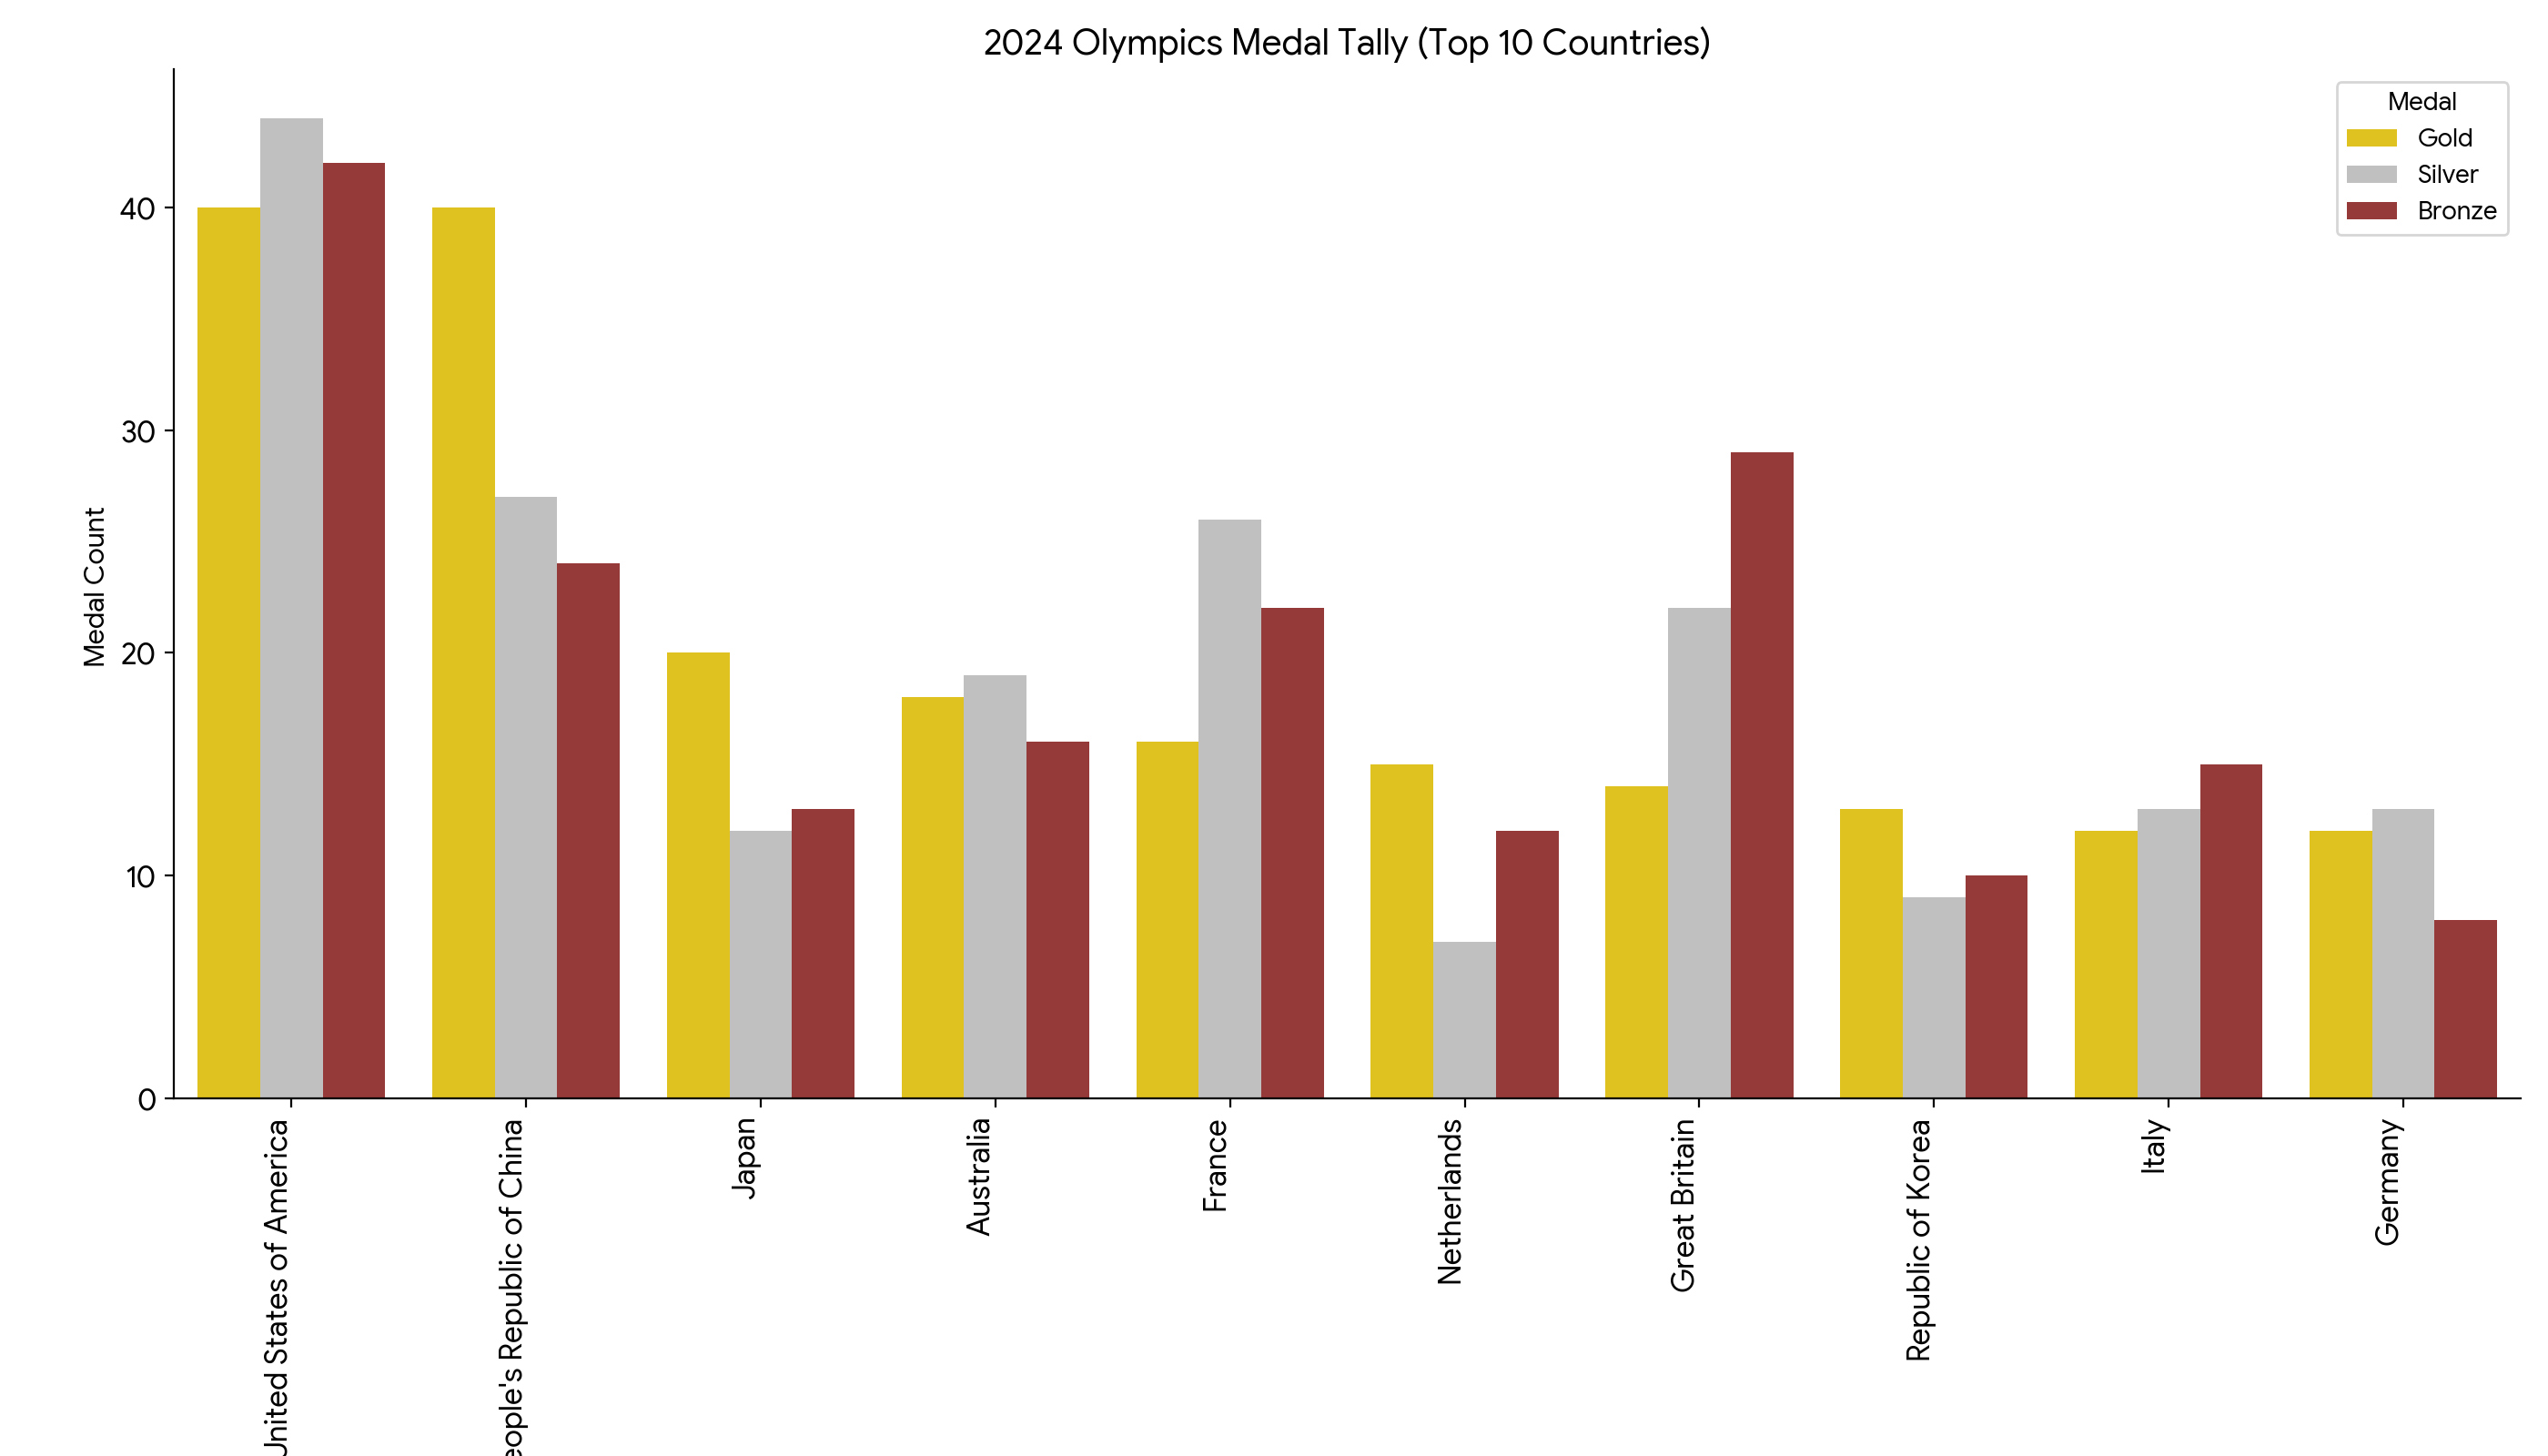

----

The chart displays the medal distribution for the top 10 countries at the 2024 Olympics. The x-axis represents the countries, and the y-axis represents the medal count. Each country has three bars representing the number of Gold, Silver, and Bronze medals they won. The colors used are gold, silver, and brown, respectively. The x-axis labels are rotated for better readability.

From the chart, we can see that the United States of America and the People's Republic of China have the highest medal counts, with the USA having a slight edge in silver and bronze. Great Britain has a high number of bronze medals.


----

In [55]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too.",
    config=config_with_code,
)

show_response(response)

## Fine tuning a custom model

In [5]:
## use Tunedmodel for start fine-tuning job
for model in client.models.list():
    if "createTunedModel" in model.supported_actions:
        print(model.name)

models/gemini-1.5-flash-001-tuning


In [7]:
## Download the dataset
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [12]:
## print how does the data looks
print(newsgroups_train.data[0])
## this number of news are there in newsgroup
print(len(newsgroups_train.data))


From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





11314


## Prepare Dataset

In [13]:
import email
import re

import pandas as pd


def preprocess_newsgroup_row(data):
    # Extract only the subject and body
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    # Strip any remaining email addresses
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    # Truncate the text to fit within the input limits
    text = text[:40000]

    return text


def preprocess_newsgroup_data(newsgroup_dataset):
    # Put data points into dataframe
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    # Clean up the text
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    # Match label to target name index
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df

In [14]:
# Apply preprocessing to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


In [15]:
def sample_data(df, num_samples, classes_to_keep):
    # Sample rows, selecting num_samples of each Label.
    df = (
        df.groupby("Label")[df.columns]
        .apply(lambda x: x.sample(num_samples))
        .reset_index(drop=True)
    )

    df = df[df["Class Name"].str.contains(classes_to_keep)]
    df["Class Name"] = df["Class Name"].astype("category")

    return df


TRAIN_NUM_SAMPLES = 50
TEST_NUM_SAMPLES = 10
# Keep rec.* and sci.*
CLASSES_TO_KEEP = "^rec|^sci"

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

In [16]:
sample_idx = 0
sample_row = preprocess_newsgroup_row(newsgroups_test.data[sample_idx])
sample_label = newsgroups_test.target_names[newsgroups_test.target[sample_idx]]

print(sample_row)
print('---')
print('Label:', sample_label)

Need info on 88-89 Bonneville


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler

---
Label: rec.autos


In [17]:
response = client.models.generate_content(
    model="gemini-1.5-flash-001", contents=sample_row)
print(response.text)

## 1988-1989 Pontiac Bonneville: Deciphering the Trim Levels

You're right, the Bonneville trim levels during those years can be confusing! Here's a breakdown to clarify:

**Base Model:** The standard Bonneville was equipped with a 3.8L V6 engine, automatic transmission, power steering, and power brakes. It offered basic features with limited options.

**LE (Luxury Edition):** This trim level added luxury features like leather upholstery, power windows, and a more refined interior.

**SE (Sport Edition):** This trim focused on performance. It included a more powerful 3.8L V6 with a higher horsepower output, sport suspension, and a sportier exterior appearance.

**LSE (Luxury Sport Edition):**  This trim combined the features of the LE and SE models. It offered the luxury features of the LE and the performance upgrades of the SE.

**SSE (Special Service Edition):** This trim level was aimed at fleet sales and typically featured a more durable interior and a longer warranty. 

**SSEi (Sp

In [18]:
# Ask the model directly in a zero-shot prompt.

prompt = "From what newsgroup does the following message originate?"
baseline_response = client.models.generate_content(
    model="gemini-1.5-flash-001",
    contents=[prompt, sample_row])
print(baseline_response.text)

While the message doesn't explicitly mention a newsgroup, it's highly likely it originates from **rec.autos.buick**. 

Here's why:

* **Content:** The message focuses on specific details of Buick Bonneville models, a topic relevant to Buick enthusiasts.
* **Similar Style:**  Newsgroup messages often have a conversational tone and directly address the reader, as seen in the message.
* **rec.autos.buick:** This newsgroup was dedicated to discussions about Buick vehicles, making it a natural fit for such a question.

While newsgroups have declined in popularity since the rise of forums and social media, they were a primary source of information and community for niche topics like car models. 



In [19]:
from google.api_core import retry

# You can use a system instruction to do more direct prompting, and get a
# more succinct answer.

system_instruct = """
You are a classification service. You will be passed input that represents
a newsgroup post and you must respond with the newsgroup from which the post
originates.
"""

# Define a helper to retry when per-minute quota is reached.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

# If you want to evaluate your own technique, replace this body of this function
# with your model, prompt and other code and return the predicted answer.
@retry.Retry(predicate=is_retriable)
def predict_label(post: str) -> str:
    response = client.models.generate_content(
        model="gemini-1.5-flash-001",
        config=types.GenerateContentConfig(
            system_instruction=system_instruct),
        contents=post)

    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        # Clean up the response.
        return response.text.strip()


prediction = predict_label(sample_row)

print(prediction)
print()
print("Correct!" if prediction == sample_label else "Incorrect.")


rec.autos.misc

Incorrect.


In [20]:
import tqdm
from tqdm.rich import tqdm as tqdmr
import warnings

# Enable tqdm features on Pandas.
tqdmr.pandas()

# But suppress the experimental warning
warnings.filterwarnings("ignore", category=tqdm.TqdmExperimentalWarning)


# Further sample the test data to be mindful of the free-tier quota.
df_baseline_eval = sample_data(df_test, 2, '.*')

# Make predictions using the sampled data.
df_baseline_eval['Prediction'] = df_baseline_eval['Text'].progress_apply(predict_label)

# And calculate the accuracy.
accuracy = (df_baseline_eval["Class Name"] == df_baseline_eval["Prediction"]).sum() / len(df_baseline_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

Accuracy: 37.50%


In [21]:
df_baseline_eval

,Text,Label,Class Name,Prediction
0,"Re: Car buying story, was: Christ, another dea...",7,rec.autos,rec.autos.buying
1,Re: Thoughts on the VW Corrado VR6\n\nIn the E...,7,rec.autos,rec.autos.vw
2,"Re: A Kinder, Gentler BMW Mailing List\n\n (Ch...",8,rec.motorcycles,rec.motorcycles.bmw
3,Re: Shaft-drives and Wheelies\n\nIn article <>...,8,rec.motorcycles,rec.motorcycles
4,The Braves will come around...\n\nTo all the B...,9,rec.sport.baseball,rec.sport.baseball
5,"Re: MVP '92 Revisited\n\nIn article <>, Tim Sh...",9,rec.sport.baseball,rec.sports.baseball.misc
6,Regular season 93/94 pool\n\n1993-1994 NHL Hoc...,10,rec.sport.hockey,rec.sport.hockey
7,Re: FLYERS:with & without Eric\n\nIn article <...,10,rec.sport.hockey,rec.sport.hockey
8,Re: From Crossbows to Cryptography\n\n> B...,11,sci.crypt,alt.politics.crypto
9,Re: Is this overreaction?\n\nPerry E. Metzger ...,11,sci.crypt,(error)


## Tune a custom model¶


In [29]:
from collections.abc import Iterable
import random


# Convert the data frame into a dataset suitable for tuning.
input_data = {'examples': 
    df_train[['Text', 'Class Name']]
      .rename(columns={'Text': 'textInput', 'Class Name': 'output'})
      .to_dict(orient='records')
 }

# If you are re-running this lab, add your model_id here.
model_id = None

# Or try and find a recent tuning job.
if not model_id:
  queued_model = None
  # Newest models first.
  for m in reversed(client.tunings.list()):
    # Only look at newsgroup classification models.
    if m.name.startswith('tunedModels/newsgroup-classification-model'):
      # If there is a completed model, use the first (newest) one.
      if m.state.name == 'JOB_STATE_SUCCEEDED':
        model_id = m.name
        print('Found existing tuned model to reuse.')
        break

      elif m.state.name == 'JOB_STATE_RUNNING' and not queued_model:
        # If there's a model still queued, remember the most recent one.
        queued_model = m.name
  else:
    if queued_model:
      model_id = queued_model
      print('Found queued model, still waiting.')


# Upload the training data and queue the tuning job.
if not model_id:
    tuning_op = client.tunings.tune(
        base_model="models/gemini-1.5-flash-001-tuning",
        training_dataset=input_data,
        config=types.CreateTuningJobConfig(
            tuned_model_display_name="Newsgroup classification model",
            batch_size=16,
            epoch_count=2,
        ),
    )

    print(tuning_op.state)
    model_id = tuning_op.name

print(model_id)

Found queued model, still waiting.
tunedModels/newsgroup-classification-model-1lbx74g7w


In [31]:
import datetime
import time


MAX_WAIT = datetime.timedelta(minutes=10)

while not (tuned_model := client.tunings.get(name=model_id)).has_ended:

    print(tuned_model.state)
    time.sleep(60)

    # Don't wait too long. Use a public model if this is going to take a while.
    if datetime.datetime.now(datetime.timezone.utc) - tuned_model.create_time > MAX_WAIT:
        print("Taking a shortcut, using a previously prepared model.")
        model_id = "tunedModels/newsgroup-classification-model-ltenbi1b"
        tuned_model = client.tunings.get(name=model_id)
        break


print(f"Done! The model state is: {tuned_model.state.name}")

if not tuned_model.has_succeeded and tuned_model.error:
    print("Error:", tuned_model.error)

JobState.JOB_STATE_RUNNING
Taking a shortcut, using a previously prepared model.
Done! The model state is: JOB_STATE_SUCCEEDED


In [33]:
new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

response = client.models.generate_content(
    model=model_id, contents=new_text)

print(response.text)


sci.space


## Evaluation of New Model

In [34]:
@retry.Retry(predicate=is_retriable)
def classify_text(text: str) -> str:
    """Classify the provided text into a known newsgroup."""
    response = client.models.generate_content(
        model=model_id, contents=text)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        return rc.content.parts[0].text


# The sampling here is just to minimise your quota usage. If you can, you should
# evaluate the whole test set with `df_model_eval = df_test.copy()`.
df_model_eval = sample_data(df_test, 4, '.*')

df_model_eval["Prediction"] = df_model_eval["Text"].progress_apply(classify_text)

accuracy = (df_model_eval["Class Name"] == df_model_eval["Prediction"]).sum() / len(df_model_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

Accuracy: 100.00%


In [35]:
# Calculate the *input* cost of the baseline model with system instructions.
sysint_tokens = client.models.count_tokens(
    model='gemini-1.5-flash-001', contents=[system_instruct, sample_row]
).total_tokens
print(f'System instructed baseline model: {sysint_tokens} (input)')

# Calculate the input cost of the tuned model.
tuned_tokens = client.models.count_tokens(model=tuned_model.base_model, contents=sample_row).total_tokens
print(f'Tuned model: {tuned_tokens} (input)')

savings = (sysint_tokens - tuned_tokens) / tuned_tokens
print(f'Token savings: {savings:.2%}')  # Note that this is only n=1.

System instructed baseline model: 172 (input)
Tuned model: 136 (input)
Token savings: 26.47%


In [36]:
baseline_token_output = baseline_response.usage_metadata.candidates_token_count
print('Baseline (verbose) output tokens:', baseline_token_output)

tuned_model_output = client.models.generate_content(
    model=model_id, contents=sample_row)
tuned_tokens_output = tuned_model_output.usage_metadata.candidates_token_count
print('Tuned output tokens:', tuned_tokens_output)

Baseline (verbose) output tokens: 149
Tuned output tokens: 3


## 